# Raspberry price analysis in the spanish market

Market Data Source: 

    Junta de Andalucía (warehouse output prices paid to farmers)

    http://www.juntadeandalucia.es/agriculturaypesca/observatorio/servlet/FrontController?action=Static&subsector=19&url=subsector.jsp

## Import and cleanance

In [119]:
import pandas as pd
import datetime
pd.set_option('display.max_columns',None) ## Display all columns in pandas dataframe  
pd.set_option('display.max_rows',None) ## Display all rows in pandas dataframe 

sheet_name = 'Observatorio de Precios'
rows_skip_13 = [1,2,3,4,5,6,7,8,9,10,11,12,13]
rows_skip_14 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
rows_skip_15 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
cols = [0,1]
file_names_year = [  
                    ['Data/FrambuesaPreciosAgricultor.xls',sheet_name,rows_skip_15,cols,'PriceProducer']\
                  ]
price = pd.DataFrame()
price = pd.read_excel(file_names_year[0][0]\
                               ,sheet_name = file_names_year[0][1]\
                               ,header = 6\
                               ,skiprows = file_names_year[0][2]\
                               ,usecols = file_names_year[0][3])
price.columns = ['Week',file_names_year[0][4]]

for i in range(1,len(file_names_year)):
    price_excel=pd.read_excel(file_names_year[i][0]\
                               ,sheet_name=file_names_year[i][1]\
                               ,header=6\
                               ,skiprows=file_names_year[i][2]\
                               ,usecols=file_names_year[i][3])
    price_excel.columns = ['Week',file_names_year[i][4]]
    price_excel.drop_duplicates(inplace=True)
    price = pd.merge(price,price_excel,\
                      how='left',\
                      on='Week')
    
price[['Week_No','Year']] = price.Week.str.split(pat='-',expand=True)
price['Date_Ref']=price['Week'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%V-%G-%u') )
price['Year'] = price['Year'].astype('int32')
price['Week_No'] = price['Week_No'].astype('int32')
price.drop(range(0,price.PriceProducer.notna().idxmax()),inplace=True)

## Checks

In [120]:
price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229 entries, 709 to 937
Data columns (total 5 columns):
Week             229 non-null object
PriceProducer    188 non-null float64
Week_No          229 non-null int32
Year             229 non-null int32
Date_Ref         229 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int32(2), object(1)
memory usage: 8.9+ KB


In [202]:
pd.set_option('display.max_columns',None) ## Display all columns in pandas dataframe  
pd.set_option('display.max_rows',None) ## Display all rows in pandas dataframe  
(price[['Year','PriceProducer']].groupby('Year').describe().unstack(1)).to_frame('Value')

Value
                    Year           
PriceProducer count 2015  16.000000
                    2016  43.000000
                    2017  42.000000
                    2018  42.000000
                    2019  41.000000
                    2020   4.000000
              mean  2015   6.256719
                    2016   5.780228
                    2017   5.720063
                    2018   6.112270
                    2019   5.557414
                    2020   6.177500
              std   2015   0.704238
                    2016   1.333772
                    2017   1.070871
                    2018   1.180118
                    2019   0.890359
                    2020   0.514352
              min   2015   4.640552
                    2016   3.152336
                    2017   3.628306
                    2018   3.322371
                    2019   4.190000
                    2020   5.440000
              25%   2015   5.689031
                    2016   4.802832
                    2017   5.045620
                    2018   5.784880
                    2019   4.873062
                    2020   6.040000
              50%   2015   6.441070
                    2016   5.772702
                    2017   5.824641
                    2018   6.123840
                    2019   5.604096
                    2020   6.330000
              75%   2015   6.880115
                    2016   6.928256
                    2017   6.540655
                    2018   6.916618
                    2019   6.140506
                    2020   6.467500
              max   2015   6.996353
                    2016   8.102199
                    2017   7.374554
                    2018   7.895787
                    2019   7.754257
                    2020   6.610000

## Average YTD in price

In [176]:
for i in range(len(price['Year'].unique())):
    price_selected = price[(price['PriceProducer'].notna()) & (price['Year']==price['Year'].unique()[i])]['PriceProducer']
    price_calculated = price_calculated.append(price_selected.cumsum() / pd.Series(np.arange(1, len(price_selected)+1),price_selected.index))
    price_calculated = (price_calculated.loc[~price_calculated.index.duplicated(keep='first')].sort_index())

price['PriceProducerMean']=price_calculated

# https://stackoverflow.com/questions/21142149/calculate-an-incremental-mean-using-python-pandas
# https://stackoverflow.com/questions/13035764/remove-rows-with-duplicate-indices-pandas-dataframe-and-timeseries

## Plot

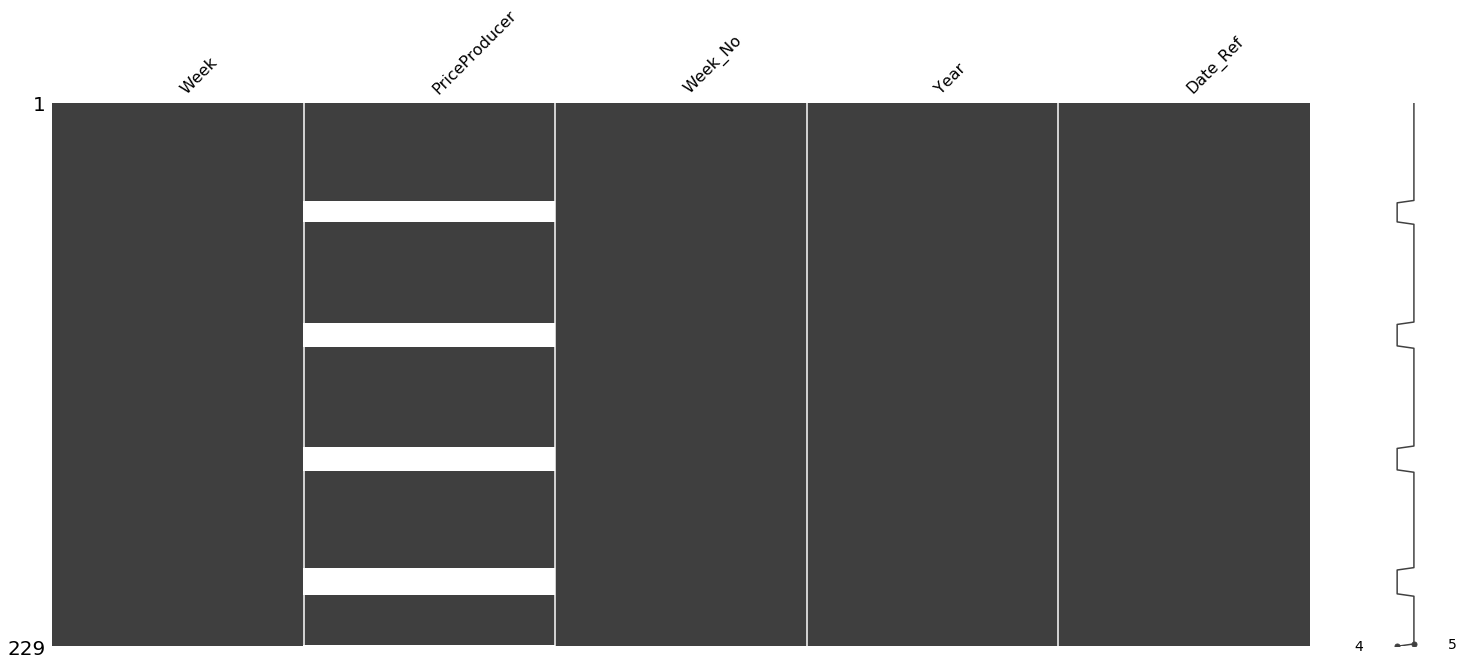

In [5]:
import missingno as msno
msno.matrix(price)

In [6]:
import pandas as pd
price.isnull().sum()

Week              0
PriceProducer    41
Week_No           0
Year              0
Date_Ref          0
dtype: int64

In [7]:
price['Week_No'][price['PriceProducer'].isna()].value_counts().reset_index().sort_values(by='index')

,index,Week_No
10,25,1
9,26,3
5,27,4
4,28,4
8,29,4
3,30,4
0,31,4
1,32,4
7,33,4
6,34,4


***Normally between weeks 26 and 35 there are no sales***

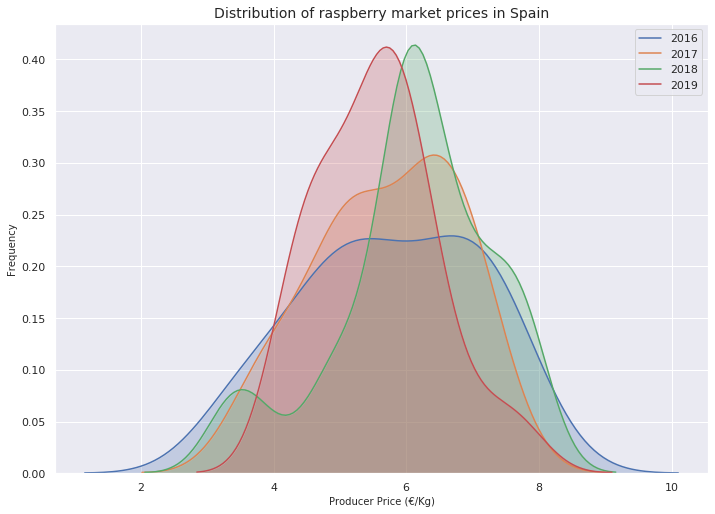

In [124]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
ax = sns.kdeplot(price[price['Year']==2016]['PriceProducer'].dropna(),label='2016', shade=True)
ax = sns.kdeplot(price[price['Year']==2017]['PriceProducer'].dropna(),label='2017', shade=True)
ax = sns.kdeplot(price[price['Year']==2018]['PriceProducer'].dropna(),label='2018', shade=True)
ax = sns.kdeplot(price[price['Year']==2019]['PriceProducer'].dropna(),label='2019', shade=True)
plt.title('Distribution of raspberry market prices in Spain', fontsize=14)
plt.xlabel('Producer Price (€/Kg)', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.savefig('distribution_raspberry.png')

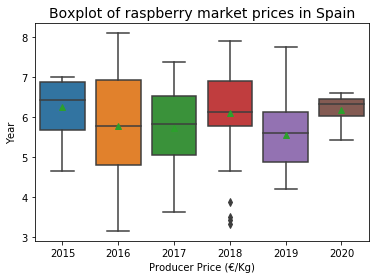

In [98]:
ax = sns.boxplot(x="Year", y="PriceProducer", data=price, showmeans=True)
plt.title('Boxplot of raspberry market prices in Spain', fontsize=14)
plt.xlabel('Producer Price (€/Kg)', fontsize=10)
plt.ylabel('Year', fontsize=10)
plt.savefig('boxplot_raspberry.png')

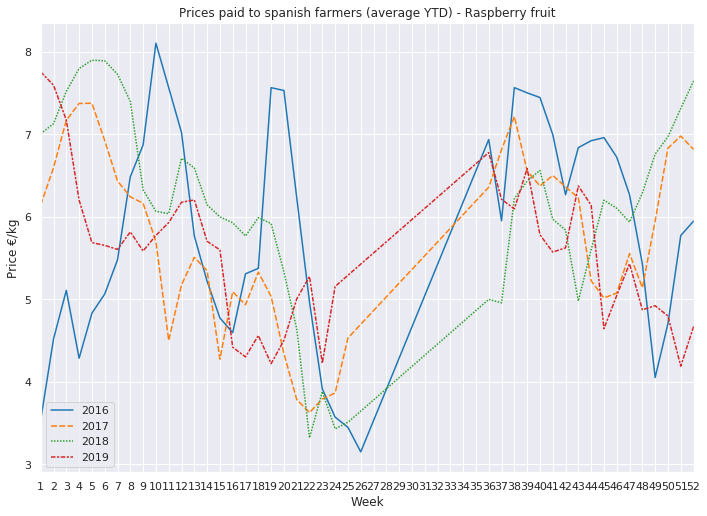

In [231]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")

s16 = price['PriceProducer'][price['Year']==2016].reset_index()
s17 = price['PriceProducer'][price['Year']==2017].reset_index()
s18 = price['PriceProducer'][price['Year']==2018].reset_index()
s19 = price['PriceProducer'][price['Year']==2019].reset_index()
price_columns=pd.concat([s16, s17, s18, s19], axis=1).reset_index()
price_columns.drop(['level_0','index'],axis=1,inplace=True)
price_columns.columns=['2016','2017','2018','2019']
price_columns.values

values = price_columns.values
dates = pd.date_range("1 1 2016", periods=52, freq="W")
data = pd.DataFrame(values, dates, columns=price_columns.columns)
data.set_index([pd.Index(range(1,53))],inplace=True)
sns.set(rc={'figure.figsize':(11.7,8.27)})

ax = sns.lineplot(data=data,\
                  palette="tab10",\
                  linewidth=1.5)
ax.set_xlim(1,52)
ax.set_xticks(range(1,53))
ax.set(xlabel='Week', ylabel='Price €/kg',title='Prices paid to spanish farmers (average YTD) - Raspberry fruit')
plt.show()

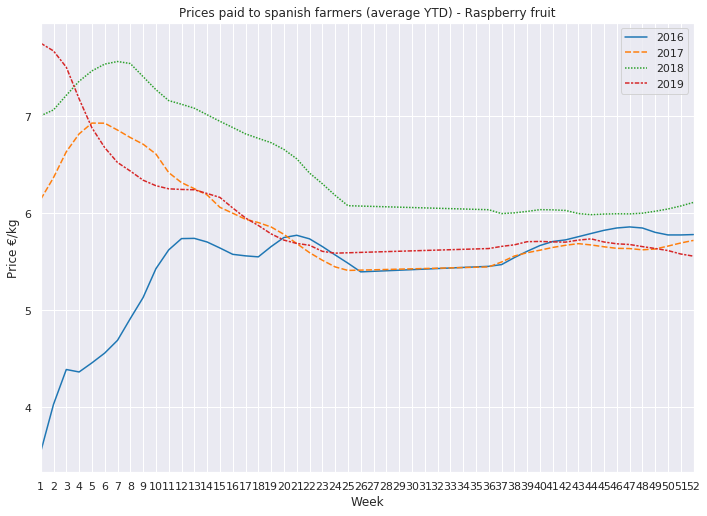

In [230]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")

s16 = price['PriceProducerMean'][price['Year']==2016].reset_index()
s17 = price['PriceProducerMean'][price['Year']==2017].reset_index()
s18 = price['PriceProducerMean'][price['Year']==2018].reset_index()
s19 = price['PriceProducerMean'][price['Year']==2019].reset_index()
price_columns=pd.concat([s16, s17, s18, s19], axis=1).reset_index()
price_columns.drop(['level_0','index'],axis=1,inplace=True)
price_columns.columns=['2016','2017','2018','2019']
price_columns.values

values = price_columns.values
dates = pd.date_range("1 1 2016", periods=52, freq="W")
data = pd.DataFrame(values, dates, columns=price_columns.columns)
data.set_index([pd.Index(range(1,53))],inplace=True)
sns.set(rc={'figure.figsize':(11.7,8.27)})

ax = sns.lineplot(data=data,\
                  palette="tab10",\
                  linewidth=1.5)
ax.set_xlim(1,52)
ax.set_xticks(range(1,53))
ax.set(xlabel='Week', ylabel='Price €/kg',title='Prices paid to spanish farmers (average YTD) - Raspberry fruit')
plt.show()

In [222]:
# https://stackoverflow.com/questions/52098537/seaborn-avoid-plotting-missing-values-line-plot
np.isnan(values)*1

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0,

In [264]:
for i in price:
    print(price['Year'].loc[i])
#price['Campaign']=price[price['Week_No']<27]['Year']
#price['Campaign']=price[price['Week_No']>=27]['Year']+1

KeyError: 'Week'